In [33]:
import numpy as np
import pandas as pd
import datetime
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [34]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

In [35]:
df_hist_trans['purchase_amount'] = np.exp(df_hist_trans['purchase_amount'])
df_new_merchant_trans['purchase_amount'] = np.exp(df_new_merchant_trans['purchase_amount'])

In [36]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [37]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [38]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [39]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

175

In [40]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

28

In [41]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,9,23,35,7,...,6.0,0.260870,0.0,0.000000,23.0,1.658319e+108,1.381361e+36,54.0,2.347826,245.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,12,24,50,7,...,0.0,0.000000,0.0,0.000000,6.0,1.658319e+108,3.557623e+25,56.0,9.333333,275.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,10,14,22,7,...,1.0,1.000000,0.0,0.000000,1.0,7.789907e+26,1.381361e+36,0.0,0.000000,246.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,6,16,20,7,...,3.0,0.428571,1.0,0.142857,7.0,2.369028e+107,1.973373e+35,41.0,5.857143,256.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,4,22,17,7,...,12.0,0.333333,2.0,0.055556,36.0,1.842577e+107,3.624714e+107,57.0,1.583333,246.0


In [42]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [43]:
list_outlier_idx = df_train[df_train.outliers == 1].index.tolist()

In [44]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [45]:
high_importance_features = [
    "hist_month_diff_mean", 
    "hist_authorized_flag_mean", 
    "hist_category_1_sum", 
    "hist_month_lag_mean", 
    "new_hist_purchase_amount_sum", 
    "new_hist_purchase_date_uptonow"
]

#smoothing
for col in high_importance_features:
    df_train[col] = np.where(df_train[col].values==0, 0.001, df_train[col].values)
    df_test[col] = np.where(df_test[col].values==0, 0.001, df_test[col].values)


for i in range(len(high_importance_features)):
    for j in range(len((high_importance_features)))[i+1:]:
        col1 = high_importance_features[i]
        col2 = high_importance_features[j]
        new_col_name = "{c1}__div__{c2}".format(c1=col1, c2=col2)
        
        df_train[new_col_name] = df_train[col1] / df_train[col2]
        df_test[new_col_name] = df_test[col1] / df_test[col2]

In [46]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [47]:
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/new_merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/prosperity_merchants_latest.csv")
df_train, df_test = merge_new_feature("../input/merchants_numerical_features.csv")
df_train, df_test = merge_new_feature("../input/merchants_item_scale_feature.csv")
df_train, df_test = merge_new_feature("../input/purchase_pattern.csv")
df_train, df_test = merge_new_feature("../input/purchase_pettern_nmf.csv")
df_train, df_test = merge_new_feature("../input/purchase_amount_pettern_nmf.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")
df_train, df_test = merge_new_feature("../input/feature_out_count_rate_summary.csv")

In [48]:
df_train["Null_count"] = df_train.isnull().sum(axis=1)
df_test["Null_count"] = df_test.isnull().sum(axis=1)

In [49]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers']]
target = df_train['target']
target_outlier = df_train["outliers"]

In [51]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    "max_bin": 256,  # なし
    'learning_rate': 0.005,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.5517	valid_1's rmse: 3.57712
[200]	training's rmse: 3.38779	valid_1's rmse: 3.4425
[300]	training's rmse: 3.28238	valid_1's rmse: 3.36685
[400]	training's rmse: 3.20799	valid_1's rmse: 3.32093
[500]	training's rmse: 3.155	valid_1's rmse: 3.29322
[600]	training's rmse: 3.11342	valid_1's rmse: 3.27529
[700]	training's rmse: 3.07916	valid_1's rmse: 3.26368
[800]	training's rmse: 3.04858	valid_1's rmse: 3.25473
[900]	training's rmse: 3.0222	valid_1's rmse: 3.24719
[1000]	training's rmse: 2.99811	valid_1's rmse: 3.24096
[1100]	training's rmse: 2.97578	valid_1's rmse: 3.23539
[1200]	training's rmse: 2.95681	valid_1's rmse: 3.23023
[1300]	training's rmse: 2.93881	valid_1's rmse: 3.22637
[1400]	training's rmse: 2.9213	valid_1's rmse: 3.22306
[1500]	training's rmse: 2.90595	valid_1's rmse: 3.21996
[1600]	training's rmse: 2.8915	valid_1's rmse: 3.21794
[1700]	training's rmse: 2.87688	valid_1's rmse: 3.

Early stopping, best iteration is:
[5812]	training's rmse: 2.51251	valid_1's rmse: 3.2351
fold 2
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.54774	valid_1's rmse: 3.57562
[200]	training's rmse: 3.37789	valid_1's rmse: 3.44416
[300]	training's rmse: 3.27142	valid_1's rmse: 3.37544
[400]	training's rmse: 3.19712	valid_1's rmse: 3.33659
[500]	training's rmse: 3.14278	valid_1's rmse: 3.31408
[600]	training's rmse: 3.10119	valid_1's rmse: 3.30061
[700]	training's rmse: 3.06618	valid_1's rmse: 3.29066
[800]	training's rmse: 3.03536	valid_1's rmse: 3.28263
[900]	training's rmse: 3.01003	valid_1's rmse: 3.27759
[1000]	training's rmse: 2.98527	valid_1's rmse: 3.27217
[1100]	training's rmse: 2.96408	valid_1's rmse: 3.26785
[1200]	training's rmse: 2.94423	valid_1's rmse: 3.26427
[1300]	training's rmse: 2.92533	valid_1's rmse: 3.26085
[1400]	training's rmse: 2.90859	valid_1's rmse: 3.25816
[1500]	training's rmse: 2.89268	valid_1's rmse: 3.25657
[1600]	tr

[2000]	training's rmse: 2.82872	valid_1's rmse: 3.23758
[2100]	training's rmse: 2.81687	valid_1's rmse: 3.23642
[2200]	training's rmse: 2.8058	valid_1's rmse: 3.23547
[2300]	training's rmse: 2.79452	valid_1's rmse: 3.23445
[2400]	training's rmse: 2.78414	valid_1's rmse: 3.234
[2500]	training's rmse: 2.77407	valid_1's rmse: 3.23359
[2600]	training's rmse: 2.76341	valid_1's rmse: 3.23312
[2700]	training's rmse: 2.75333	valid_1's rmse: 3.23252
[2800]	training's rmse: 2.74435	valid_1's rmse: 3.23207
[2900]	training's rmse: 2.73504	valid_1's rmse: 3.23162
[3000]	training's rmse: 2.72566	valid_1's rmse: 3.23096
[3100]	training's rmse: 2.71671	valid_1's rmse: 3.23033
[3200]	training's rmse: 2.70801	valid_1's rmse: 3.2301
[3300]	training's rmse: 2.69951	valid_1's rmse: 3.22976
[3400]	training's rmse: 2.69165	valid_1's rmse: 3.22947
[3500]	training's rmse: 2.68328	valid_1's rmse: 3.22925
[3600]	training's rmse: 2.67549	valid_1's rmse: 3.22887
[3700]	training's rmse: 2.66709	valid_1's rmse: 3.22

3.2312772087401873

In [52]:
# score:  3.6467757129353053

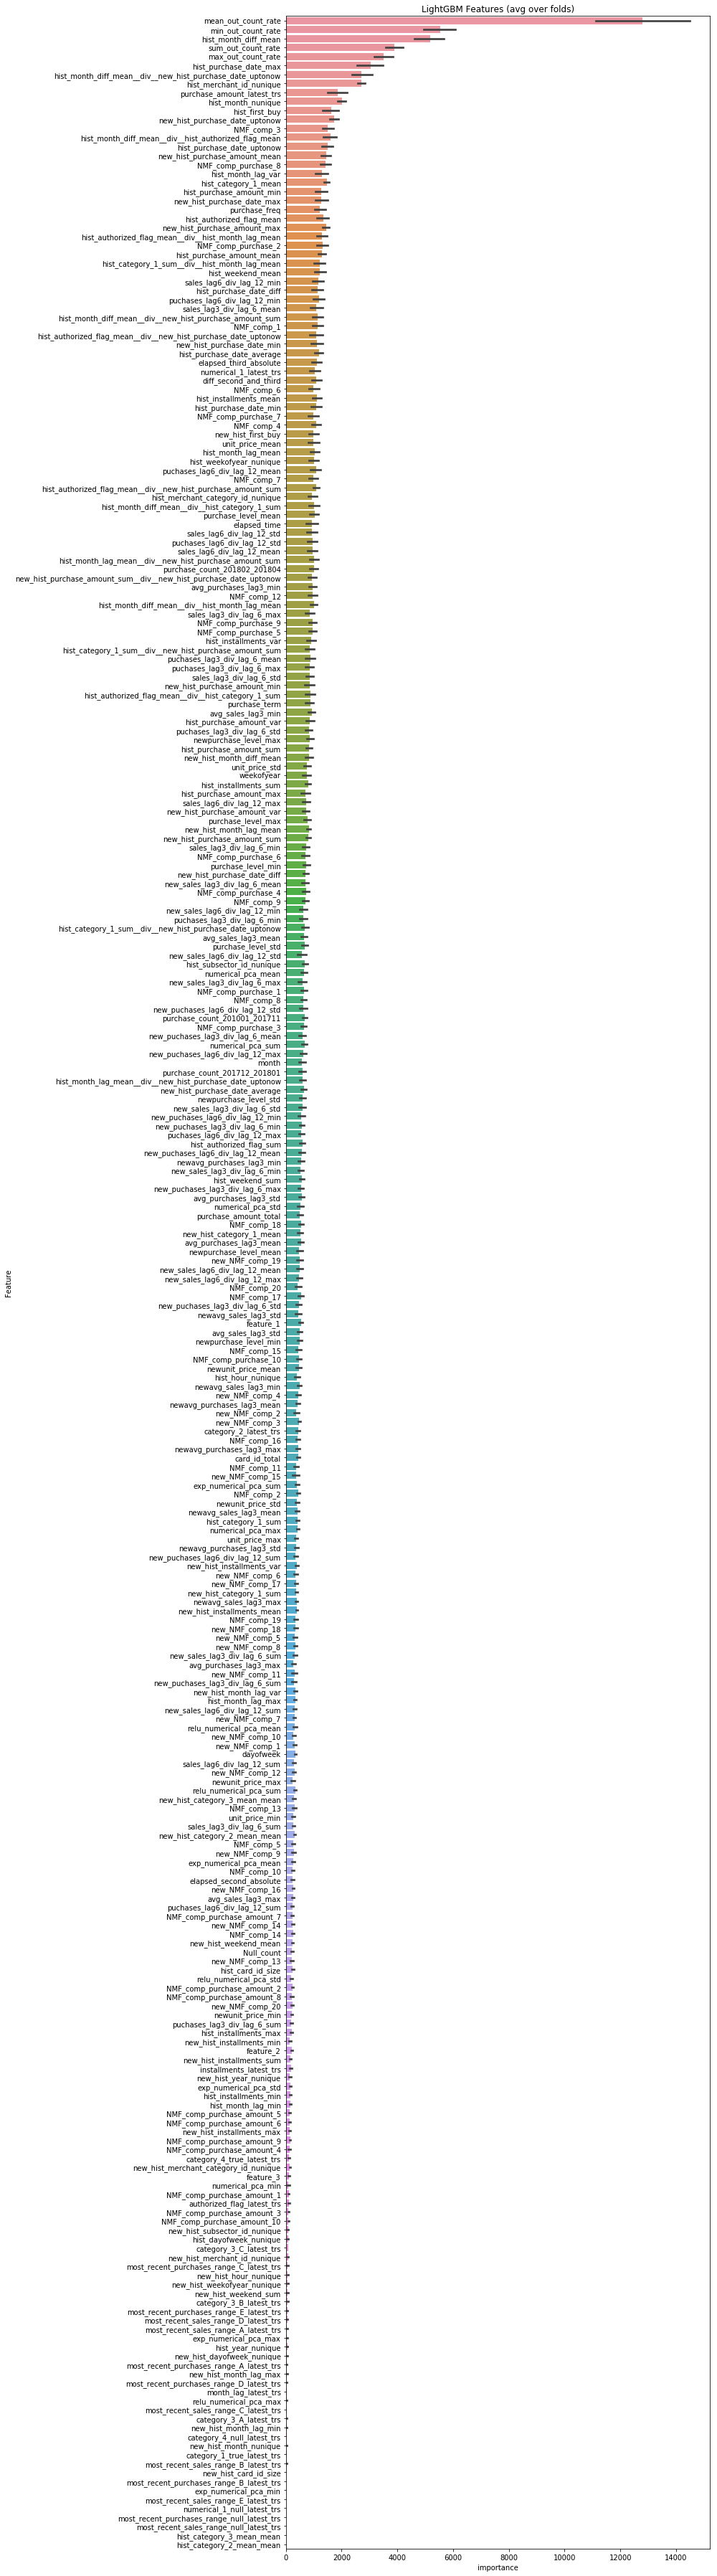

In [53]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [67]:
df_train2 = df_train[df_train.target >= -20].reset_index(drop=True)
target2 = df_train2["target"]

#original
param2 = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.01,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train2))
predictions2 = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train2,df_train2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train2.iloc[trn_idx][df_train_columns], label=target2.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train2.iloc[val_idx][df_train_columns], label=target2.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param2, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions2 += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target2))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.60708	valid_1's rmse: 1.60695
[200]	training's rmse: 1.57525	valid_1's rmse: 1.57847
[300]	training's rmse: 1.55973	valid_1's rmse: 1.56739
[400]	training's rmse: 1.54905	valid_1's rmse: 1.56148
[500]	training's rmse: 1.54055	valid_1's rmse: 1.55821
[600]	training's rmse: 1.53328	valid_1's rmse: 1.55587
[700]	training's rmse: 1.52685	valid_1's rmse: 1.55444
[800]	training's rmse: 1.52101	valid_1's rmse: 1.55361
[900]	training's rmse: 1.51569	valid_1's rmse: 1.55301
[1000]	training's rmse: 1.51069	valid_1's rmse: 1.5526
[1100]	training's rmse: 1.50597	valid_1's rmse: 1.55229
[1200]	training's rmse: 1.50144	valid_1's rmse: 1.552
[1300]	training's rmse: 1.49705	valid_1's rmse: 1.55181
[1400]	training's rmse: 1.49276	valid_1's rmse: 1.55167
[1500]	training's rmse: 1.48853	valid_1's rmse: 1.55152
[1600]	training's rmse: 1.48431	valid_1's rmse: 1.55129
[1700]	training's rmse: 1.48014	valid_1's rmse

[1100]	training's rmse: 1.50047	valid_1's rmse: 1.578
[1200]	training's rmse: 1.49582	valid_1's rmse: 1.57774
[1300]	training's rmse: 1.49134	valid_1's rmse: 1.57756
[1400]	training's rmse: 1.48702	valid_1's rmse: 1.57739
[1500]	training's rmse: 1.4828	valid_1's rmse: 1.57726
[1600]	training's rmse: 1.47869	valid_1's rmse: 1.57723
[1700]	training's rmse: 1.47462	valid_1's rmse: 1.57714
[1800]	training's rmse: 1.47057	valid_1's rmse: 1.57698
[1900]	training's rmse: 1.46667	valid_1's rmse: 1.57694
[2000]	training's rmse: 1.46282	valid_1's rmse: 1.57698
[2100]	training's rmse: 1.45905	valid_1's rmse: 1.57705
[2200]	training's rmse: 1.45525	valid_1's rmse: 1.57697
[2300]	training's rmse: 1.4515	valid_1's rmse: 1.5769
[2400]	training's rmse: 1.44785	valid_1's rmse: 1.57689
[2500]	training's rmse: 1.44409	valid_1's rmse: 1.57695
[2600]	training's rmse: 1.44043	valid_1's rmse: 1.57694
[2700]	training's rmse: 1.4368	valid_1's rmse: 1.57698
Early stopping, best iteration is:
[2324]	training's r

1.5562622012364913

In [68]:
df_prediction = pd.DataFrame({"prediction1":predictions, "prediction2":predictions2})
df_prediction

,prediction1,prediction2
0,-0.776705,-0.576543
1,-0.282078,-0.325371
2,-0.740959,-0.361586
3,-0.154199,-0.097735
4,-1.682709,-1.793248
5,0.207359,0.547805
6,0.125610,0.168009
7,0.821773,0.768376
8,-0.668980,-0.739997
9,-0.513189,-0.199306


In [69]:
predictions3 = np.zeros(df_prediction.shape[0])
for i, r in df_prediction.iterrows():
    if r[0] < 0 :
        predictions3[i] = r[0]
    else:
        predictions3[i] = r[1]
df_prediction["prediction3"] = predictions3

In [70]:
df_prediction

,prediction1,prediction2,prediction3
0,-0.776705,-0.576543,-0.776705
1,-0.282078,-0.325371,-0.282078
2,-0.740959,-0.361586,-0.740959
3,-0.154199,-0.097735,-0.154199
4,-1.682709,-1.793248,-1.682709
5,0.207359,0.547805,0.547805
6,0.125610,0.168009,0.168009
7,0.821773,0.768376,0.768376
8,-0.668980,-0.739997,-0.668980
9,-0.513189,-0.199306,-0.513189


In [71]:
final_predictions = df_prediction.prediction3.values

In [72]:
# import optuna

# def objective(trial):
#     train_x, test_x, train_y, test_y = train_test_split(df_train[df_train_columns], target, test_size=0.20, random_state=4590)
    
#     dtrain = lgb.Dataset(train_x, label=train_y)
#     dval = lgb.Dataset(test_x, label=test_y)

#     num_round = trial.suggest_int('num_round', 1, 10000)
#     param = {
#         'objective': 'regression', 
#         'metric': 'rmse',
#         'verbosity': -1,
#         'feature_fraction': trial.suggest_loguniform('feature_fraction', 0.8, 0.95),
#         'bagging_fraction': trial.suggest_loguniform('bagging_fraction', 0.8, 0.95),
#         'bagging_seed': 11,
#         'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
#         'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
#         'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 10, 1000),
#         'lambda_l1':  trial.suggest_loguniform('lambda_l1', 1e-2, 1.0)
#     }

#     if param['boosting_type'] == 'dart':
#         param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-4, 1.0)
#         param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-4, 1.0)
#     if param['boosting_type'] == 'goss':
#         param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
#         param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])

#     gbm = lgb.train(param, dtrain, num_round, valid_sets = [dtrain, dval], verbose_eval=100, early_stopping_rounds=400)
#     preds = gbm.predict(test_x)
#     pred_labels = np.rint(preds)
#     rmse = np.sqrt(mean_squared_error(test_y, pred_labels))
#     return rmse

# study = optuna.create_study()
# study.optimize(objective, n_trials=20)

# print('Number of finished trials: {}'.format(len(study.trials)))

# print('Best trial:')
# trial = study.best_trial

# print('  Value: {}'.format(trial.value))

# print('  Params: ')
# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

In [54]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
# sub_df["target"] = final_predictions
sub_df["target"] = predictions
sub_df.to_csv("../output/submission_model20181229.csv", index=False)